## Step 0: Enviroment setting

In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Step 1: Load the dataset files

In [3]:
dataset_root = '/kaggle/input/kermany2018/OCT2017 ' 
train_dir = os.path.join(dataset_root, 'train')
val_dir = os.path.join(dataset_root, 'val')
test_dir = os.path.join(dataset_root, 'test')

## Step 2a: Create training datasets

In [4]:
# Define data generator 

seed = 10

train_datagen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator()

In [5]:
train_ds = train_datagen.flow_from_directory(train_dir, 
                                             target_size=(224,224),
                                             subset='training',
                                             seed=seed,
                                             class_mode="categorical")

Found 66788 images belonging to 4 classes.


In [6]:
val_ds = train_datagen.flow_from_directory(train_dir, 
                                           target_size=(224,224),
                                           subset='validation',
                                           seed=seed,
                                           class_mode="categorical")

Found 16696 images belonging to 4 classes.


In [7]:
test_ds = test_datagen.flow_from_directory(test_dir, 
                                             target_size=(224,224),
                                             class_mode="categorical")

Found 968 images belonging to 4 classes.


## Step 2b: Create training undersampled datasets

Text(0.5, 1.0, 'Images distribution by class')

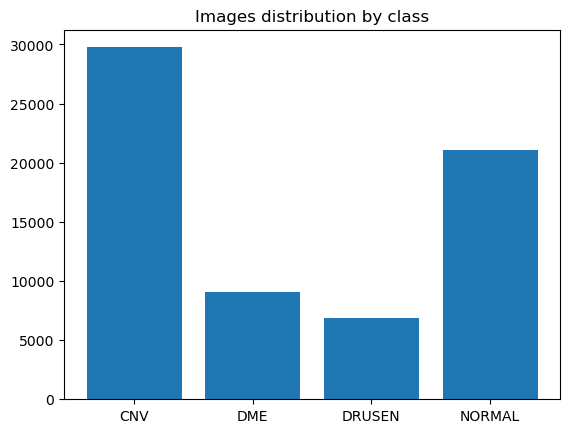

In [8]:
# Explore class imbalance

train_paths = train_ds.filenames

CNV = len([path for path in train_paths if os.path.basename(path).startswith("CNV")])
DME = len([path for path in train_paths if os.path.basename(path).startswith("DME")])
DRUSEN = len([path for path in train_paths if os.path.basename(path).startswith("DRUSEN")])
NORMAL = len([path for path in train_paths if os.path.basename(path).startswith("NORMAL")])

count = np.array([CNV, DME, DRUSEN, NORMAL])
total = sum(count)

plt.bar(['CNV', 'DME', 'DRUSEN', 'NORMAL'],count)
plt.title('Images distribution by class')

In [9]:
# Get images paths

cnv_paths = []
dme_paths = []
drusen_paths = []
normal_paths = []

for path in train_paths:
    filename = os.path.basename(path)
    
    if filename.startswith("CNV"):
        cnv_paths.append(path)
    elif filename.startswith("DME"):
        dme_paths.append(path)
    elif filename.startswith("DRUSEN"):
        drusen_paths.append(path)
    elif filename.startswith("NORMAL"):
        normal_paths.append(path)

max_length = max(len(cnv_paths), len(dme_paths), len(drusen_paths), len(normal_paths))

cnv_paths += [np.NAN] * (max_length - len(cnv_paths))
dme_paths += [np.NAN] * (max_length - len(dme_paths))
drusen_paths += [np.NAN] * (max_length - len(drusen_paths))
normal_paths += [np.NAN] * (max_length - len(normal_paths))

paths_list = {'CNV_path': cnv_paths,
                'DME_path': dme_paths,
                'DRUSEN_path': drusen_paths,
                'NORMAL_path': normal_paths}

train_paths_df = pd.DataFrame(paths_list)
train_paths_df.head(5)

,CNV_path,DME_path,DRUSEN_path,NORMAL_path
0,CNV/CNV-2158467-7.jpeg,DME/DME-3441556-96.jpeg,DRUSEN/DRUSEN-228939-16.jpeg,NORMAL/NORMAL-2517546-2.jpeg
1,CNV/CNV-2158467-8.jpeg,DME/DME-3441556-97.jpeg,DRUSEN/DRUSEN-228939-17.jpeg,NORMAL/NORMAL-2517546-3.jpeg
2,CNV/CNV-2158467-9.jpeg,DME/DME-3441556-98.jpeg,DRUSEN/DRUSEN-228939-18.jpeg,NORMAL/NORMAL-2517546-4.jpeg
3,CNV/CNV-2158821-1.jpeg,DME/DME-3441556-99.jpeg,DRUSEN/DRUSEN-228939-19.jpeg,NORMAL/NORMAL-2517546-5.jpeg
4,CNV/CNV-2158821-10.jpeg,DME/DME-3447259-1.jpeg,DRUSEN/DRUSEN-228939-2.jpeg,NORMAL/NORMAL-2517546-6.jpeg


In [10]:
# Undersampling

random_paths_df = train_paths_df.sample(frac=1, random_state=42) # Sort the paths randomly

undersampled_paths = random_paths_df.dropna(subset=['DRUSEN_path']) # Minor class

undersampled_paths_df = pd.melt(undersampled_paths, value_vars=['CNV_path', 'DME_path', 'DRUSEN_path', 
                                                                'NORMAL_path'], value_name='path').drop('variable', axis=1)

undersampled_paths_df = undersampled_paths_df.reset_index(drop=True)

In [11]:
# Assign class to each image

def get_class_from_path(path):
    if path.startswith('CNV'):
        return 'CNV'
    elif path.startswith('DME'):
        return 'DME'
    elif path.startswith('DRUSEN'):
        return 'DRUSEN'
    elif path.startswith('NORMAL'):
        return 'NORMAL'
    else:
        return None  # Handle cases where path doesn't match any class

undersampled_paths_df['class'] = undersampled_paths_df['path'].apply(get_class_from_path)
undersampled_paths_df.head(5)

,path,class
0,CNV/CNV-457907-51.jpeg,CNV
1,CNV/CNV-364469-61.jpeg,CNV
2,CNV/CNV-3215445-37.jpeg,CNV
3,CNV/CNV-451136-252.jpeg,CNV
4,CNV/CNV-2760476-8.jpeg,CNV


In [12]:
# Generate undersampled dataset

under_datagen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)

under_train_ds = under_datagen.flow_from_dataframe(dataframe=undersampled_paths_df,
                                                                directory=train_dir,
                                                                x_col="path",
                                                                y_col="class",
                                                                class_mode ="categorical",
                                                                target_size=(224,224),
                                                                seed=seed)

Found 27572 validated image filenames belonging to 4 classes.


Text(0.5, 1.0, 'Images distribution by class')

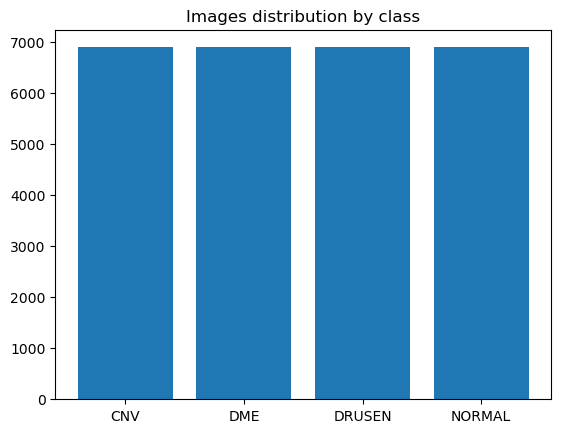

In [13]:
# Explore class imbalance

under_train_paths = under_train_ds.filenames

CNV_under = len([path for path in under_train_paths if os.path.basename(path).startswith("CNV")])
DME_under = len([path for path in under_train_paths if os.path.basename(path).startswith("DME")])
DRUSEN_under = len([path for path in under_train_paths if os.path.basename(path).startswith("DRUSEN")])
NORMAL_under = len([path for path in under_train_paths if os.path.basename(path).startswith("NORMAL")])

count_under = np.array([CNV_under, DME_under, DRUSEN_under, NORMAL_under])

plt.bar(['CNV', 'DME', 'DRUSEN', 'NORMAL'],count_under)
plt.title('Images distribution by class')

## Step 3: Visualizations

In [14]:
def view_image(ds):
    image, label = next(iter(ds))
    image = image 
    label = label 

    fig = plt.figure(figsize=(22, 22))
    for i in range(4):
        ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i].astype(np.int32))

        # Determine the position of the 1 in the label array
        position = np.where(label[i] == 1)[0][0]

        # Assign the corresponding name based on the position
        if position == 0:
            name = 'CNV'
        elif position == 1:
            name = 'DME'
        elif position == 2:
            name = 'DRUSEN'
        elif position == 3:
            name = 'NORMAL'
        else:
            name = 'Unknown'
        ax.set_title(f"Label: {name}")

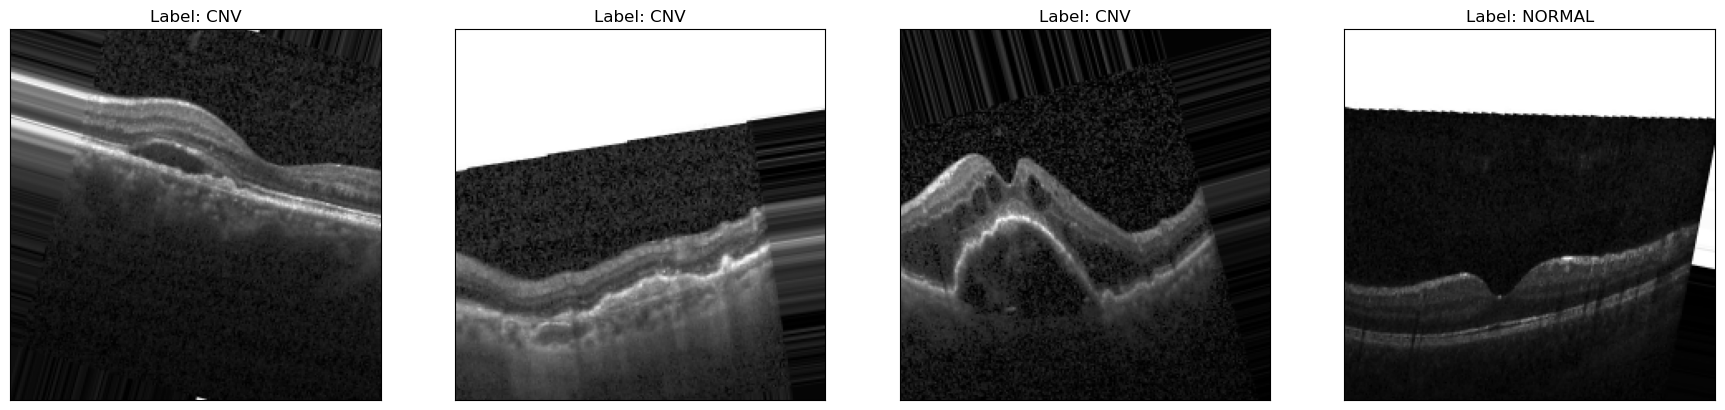

In [15]:
view_image(train_ds)

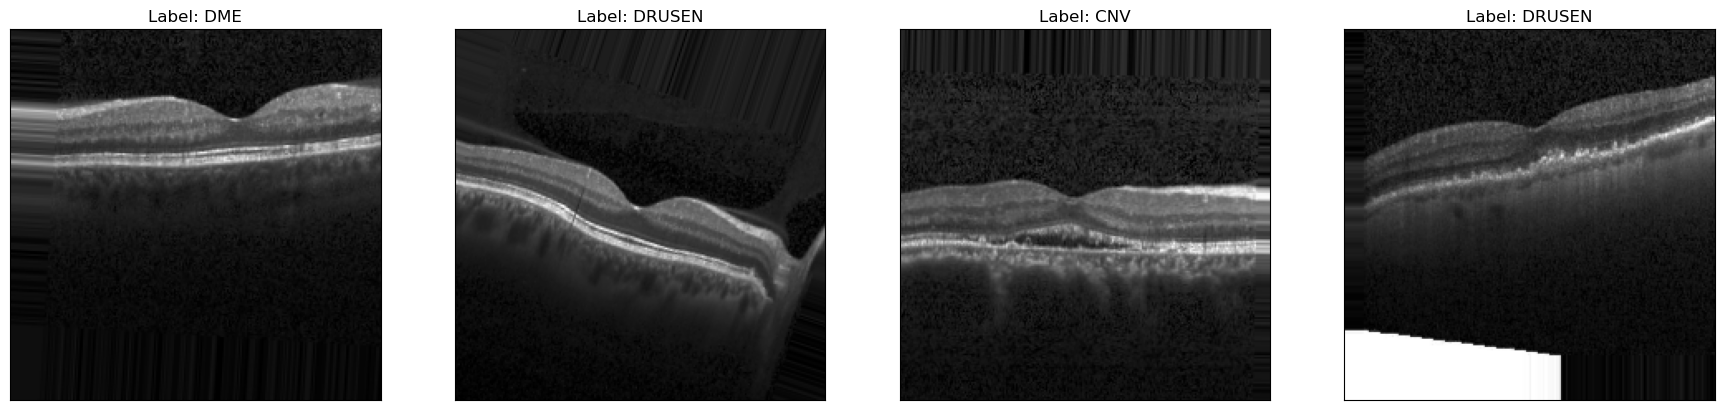

In [16]:
view_image(under_train_ds)

## Step 4: Model Creation

In [17]:
def create_model(input_shape=(224,224,3),output_units=4):
    
    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.layers.Input(input_shape)
    pool = tf.keras.layers.GlobalAveragePooling2D()
    flatten = tf.keras.layers.Flatten()
    softmax = tf.keras.layers.Dense(output_units, activation='softmax')
    
    x = inputs
    x = preprocess(x)
    x = base_model(x)
    x = pool(x)
    x = flatten(x)
    out = softmax(x)
    
    return tf.keras.Model(inputs=inputs, outputs=out)

## Metric tracker

In [18]:
# Define custom metrics
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_val = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_val

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall_val = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_val

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_val = 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    return f1_val

# Define metrics list
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score]

## Step 6: Train model with weighted classes

In [19]:
# Define weights

weights = total/count/ len(count)
weights /= weights.min()
class_weight = {i: w for i, w in enumerate(weights)}
class_weight

{0: 1.0, 1: 3.2783346183500384, 2: 4.31800377194255, 3: 1.4138324149724493}

In [20]:
resnet_wg = create_model()
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
            tf.keras.callbacks.ModelCheckpoint(filepath='resnet_model.{epoch:02d}-{val_loss:.2f}.h5')]

resnet_wg.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=metrics)

resnet_wg_history = resnet_wg.fit(train_ds,
                                   validation_data=val_ds,
                                   callbacks=callbacks,
                                   class_weight=class_weight,
                                   epochs=20)

94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/20
2088/2088 [==============================] - 1569s 747ms/step - loss: 1.2557 - accuracy: 0.7481 - precision: 0.7978 - recall: 0.6862 - f1_score: 0.7343 - val_loss: 0.5292 - val_accuracy: 0.8017 - val_precision: 0.8393 - val_recall: 0.7563 - val_f1_score: 0.7949
Epoch 2/20
2088/2088 [==============================] - 1171s 561ms/step - loss: 1.0761 - accuracy: 0.7896 - precision: 0.8208 - recall: 0.7528 - f1_score: 0.7846 - val_loss: 0.5080 - val_accuracy: 0.8015 - val_precision: 0.8372 - val_recall: 0.7622 - val_f1_score: 0.7972
Epoch 3/20
2088/2088 [==============================] - 1142s 547ms/step - loss: 1.0337 - accuracy: 0.7970 - precision: 0.8247 - recall: 0.7659 - f1_score: 0.7938 - val_loss: 0.4799 - val_accuracy: 0.8246 - val_precision: 0.8521 - val_recall: 0.7969 - val_f1_score: 0.8233
Epoch 4/20
2088/2088 [==============================] - 1162s 557ms/step - loss: 1.0046 - accuracy: 0.8018 - precisi

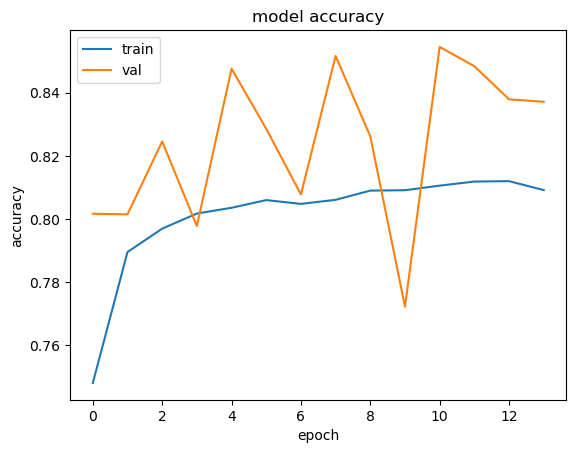

In [21]:
#plot accuracy

plt.plot(resnet_wg_history.history['accuracy'])
plt.plot(resnet_wg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

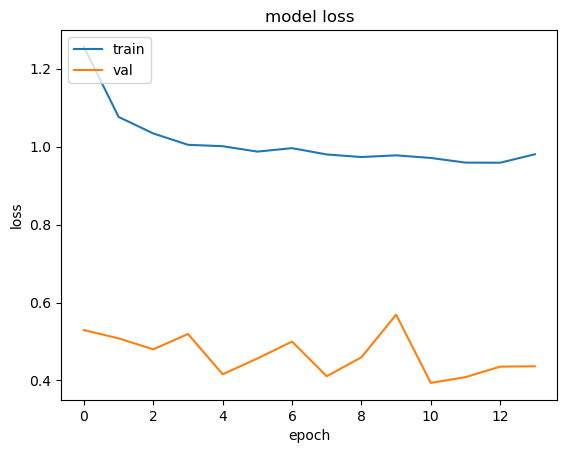

In [22]:
# Plot losses

plt.plot(resnet_wg_history.history['loss'])
plt.plot(resnet_wg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [23]:
# Train on test dataset 
resnet_wg.evaluate(test_ds)

31/31 [==============================] - 9s 303ms/step - loss: 0.1883 - accuracy: 0.9401 - precision: 0.9448 - recall: 0.9370 - f1_score: 0.9362


[0.18827852606773376,
 0.9400826692581177,
 0.9447916746139526,
 0.9369834661483765,
 0.9361879229545593]

## Step 7: Train model on undersampled dataset

In [24]:
resnet_under = create_model()

optimizer = tf.keras.optimizers.Adam(lr=1e-4)

resnet_under.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=metrics)

resnet_under_history = resnet_under.fit(under_train_ds,
                                   validation_data=val_ds,
                                   callbacks=callbacks,
                                   epochs=20)

Epoch 1/20
862/862 [==============================] - 631s 728ms/step - loss: 0.7319 - accuracy: 0.7086 - precision: 0.7813 - recall: 0.6315 - f1_score: 0.6828 - val_loss: 0.5601 - val_accuracy: 0.7862 - val_precision: 0.8387 - val_recall: 0.7283 - val_f1_score: 0.7785
Epoch 2/20
862/862 [==============================] - 645s 748ms/step - loss: 0.5974 - accuracy: 0.7732 - precision: 0.8128 - recall: 0.7206 - f1_score: 0.7632 - val_loss: 0.4883 - val_accuracy: 0.8101 - val_precision: 0.8474 - val_recall: 0.7744 - val_f1_score: 0.8087
Epoch 3/20
862/862 [==============================] - 638s 740ms/step - loss: 0.5660 - accuracy: 0.7846 - precision: 0.8199 - recall: 0.7400 - f1_score: 0.7772 - val_loss: 0.5430 - val_accuracy: 0.7923 - val_precision: 0.8356 - val_recall: 0.7478 - val_f1_score: 0.7883
Epoch 4/20
862/862 [==============================] - 604s 701ms/step - loss: 0.5484 - accuracy: 0.7919 - precision: 0.8250 - recall: 0.7537 - f1_score: 0.7872 - val_loss: 0.4685 - val_accur

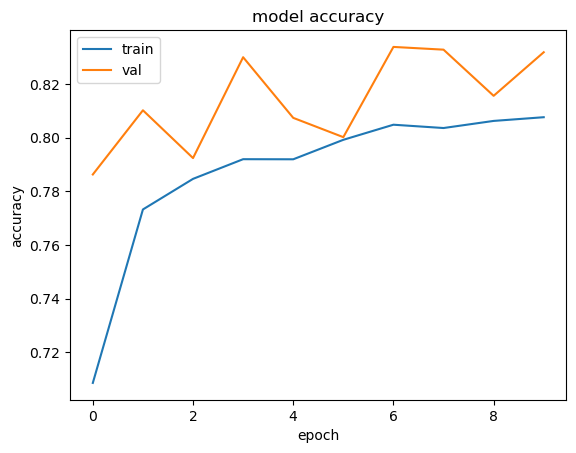

In [25]:
# Plot accuracy

plt.plot(resnet_under_history.history['accuracy'])
plt.plot(resnet_under_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

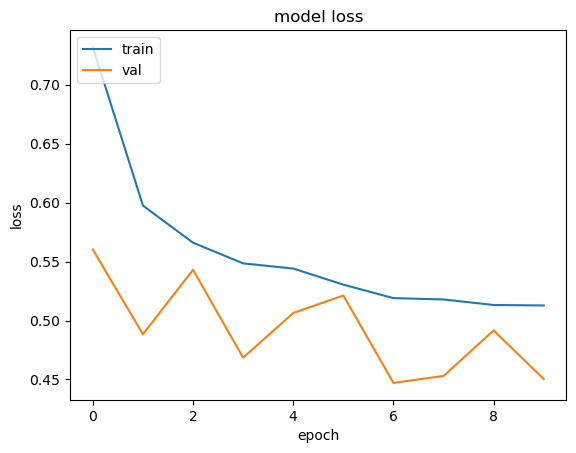

In [26]:
# Plot losses

plt.plot(resnet_under_history.history['loss'])
plt.plot(resnet_under_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Train on test dataset 

resnet_under.evaluate(test_ds)

31/31 [==============================] - 4s 141ms/step - loss: 0.2055 - accuracy: 0.9370 - precision: 0.9476 - recall: 0.9339 - f1_score: 0.9420


[0.2055482119321823,
 0.9369834661483765,
 0.947589099407196,
 0.93388432264328,
 0.9419916272163391]